# DenseNet121 Model

Before running this notebook, please make sure to run the `AugmentAndSplit.ipynb` notebook beforehand.

## This notebook has the following sections:

1. Prerequisites

2. Grid Search

3. Training using the Best Hyperparameters

4. Model Evaluation using a Confusion Matrix

5. Model Evaluation using K-Fold Cross Validation

# Section 1 - Prerequisites

In this section, we will import all the necessary libraries to run the notebook, define constants and invariants, and define the architecture of our model.

In [2]:
"""
Log dependency versions for reproducibility
"""
import sys
print("python",  sys.version)
import matplotlib
print("matplotlib", matplotlib.__version__)
import pandas
print("pandas", pandas.__version__)
import numpy
print("numpy", numpy.__version__)
import keras
print("keras", keras.__version__)
import tensorflow
print("tensorflow", tensorflow.__version__)
import sklearn
print("sklearn", sklearn.__version__)
import scikeras
print("scikeras", scikeras.__version__)

python 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
matplotlib 3.10.0
pandas 2.2.3
numpy 1.26.4
keras 3.9.0
tensorflow 2.15.0
sklearn 1.3.1
scikeras 0.13.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# Loading Datasets and Models
from keras.utils import image_dataset_from_directory
from keras.saving import load_model

# Saving Results
import os
import json

# Building our Model
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications.densenet import DenseNet121, preprocess_input # DenseNet121

# Compiling our Model
from keras.optimizers import SGD, Adam, RMSprop

# Grid Search
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# K-Fold
from sklearn.model_selection import KFold

In [4]:
"""
Constants and Invariant Parameters
"""
# Invariant parameters
BATCH_SIZE = 16
EPOCHS = 10 # Due to limited hardware, we will only compute up to 10 epochs for realistic runtime constraints
VALIDATION_SPLIT = 0.2
SEED = 42

# Model tuning and evaluation
GRID_SEARCH_ITERATIONS = 2 # Number of attempts per hyperparameter combination (the score of these attempts will be averaged)
K_FOLDS = 5

# Constants
IMAGE_SIZE = (150, 150)
OPTIMIZERS = {
    "Adam": Adam,
    "SGD": SGD,
    "RMSprop": RMSprop,
}

# File and directory management
INPUT_DIRECTORY = "training_and_validation_dataset"
TESTING_DIRECTORY = "testing_dataset"
MODEL_NAME = "DenseNet121"

In [8]:
"""
Define the model architecture
"""
densenet = DenseNet121(
    input_shape=IMAGE_SIZE + tuple([3]), # (150, 150, 3)
    weights="imagenet",                  # Use pre-trained weights
    include_top=False,                   # Remove top layer to add our own layers
)

# Freeze the pre-trained weights
for layer in densenet.layers:
    layer.trainable = False

def create_model(optimizer="SGD", learning_rate=0.001):
    model = Sequential([
        densenet,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])

    optimizer = OPTIMIZERS[optimizer]

    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Section 2 - Grid Search
In this section, we will perform grid search on our model to tune our chosen hyperparameters. The best hyperparameter configuration will be determined and saved into a .csv file.

In [6]:
"""
Define hyperparameter grid
"""
# Use the model prefix for compatibility with the GridSearch API
param_grid = {
    "model__optimizer": ["Adam", "SGD", "RMSprop"],
    "model__learning_rate": [0.0001, 0.001, 0.01],
}

In [9]:
"""
Load the training dataset
"""
training_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)
validation_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)

# Apply ResNet50's image preprocessing
training_dataset = training_dataset.map(lambda x, y: (preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))

Found 712 files belonging to 2 classes.
Using 570 files for training.
Found 712 files belonging to 2 classes.
Using 142 files for validation.


In [8]:
"""
Prepare the data to be compatible with the GridSearch API
"""

# Function to convert TF dataset to NumPy arrays
def dataset_to_numpy(dataset):
    all_images, all_labels = [], []
    for images, labels in dataset:
        all_images.append(images.numpy())  # Convert images to NumPy
        all_labels.append(labels.numpy())  # Convert labels to NumPy
    return np.vstack(all_images), np.hstack(all_labels)

# Convert datasets for GridSearch compatibility
training_images, training_labels = dataset_to_numpy(training_dataset)
validation_images, validation_labels = dataset_to_numpy(validation_dataset)

# Wrap model for GridSearch compatibility
model = KerasClassifier(model=create_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

In [10]:
"""
Perform Grid Search
"""
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=GRID_SEARCH_ITERATIONS
)
grid_result = grid.fit(
    training_images,
    training_labels,
    validation_data=(
        validation_images,
        validation_labels
    )
)

# Output best parameters
print(f"Best Params: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 662ms/step - accuracy: 0.5546 - loss: 1.1589 - val_accuracy: 0.6901 - val_loss: 0.5641
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.6699 - loss: 0.7081 - val_accuracy: 0.7746 - val_loss: 0.4279
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.6940 - loss: 0.6385 - val_accuracy: 0.8521 - val_loss: 0.3599
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.7527 - loss: 0.6072 - val_accuracy: 0.8732 - val_loss: 0.3194
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8092 - loss: 0.4648 - val_accuracy: 0.8873 - val_loss: 0.2941
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.7597 - loss: 0.4751 - val_accuracy: 0.8944 - val_loss: 0.2721
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.8295 - loss: 0.3919 - val_accuracy: 0.8944 - val_loss: 0.2570
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.8210 - loss: 0.3455 - val_accuracy: 0

2025-03-23 09:22:02.933326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5840 - loss: 1.1346 - val_accuracy: 0.6197 - val_loss: 0.7785
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 515ms/step - accuracy: 0.6369 - loss: 0.9006 - val_accuracy: 0.7183 - val_loss: 0.5839
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.6549 - loss: 0.7740 - val_accuracy: 0.7394 - val_loss: 0.5485
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.7410 - loss: 0.5936 - val_accuracy: 0.7606 - val_loss: 0.4349
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.7769 - loss: 0.4918 - val_accuracy: 0.8099 - val_loss: 0.4009
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.7985 - loss: 0.4672 - val_accuracy: 0.8169 - val_loss: 0.3998
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.8133 - loss: 0.4152 - val_accuracy: 0.8169 - val_loss: 0.3592
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.8168 - loss: 0.3652 - val_accuracy: 0.8521 - val_l

2025-03-23 09:23:26.966234: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 759ms/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5973 - loss: 1.0330 - val_accuracy: 0.5986 - val_loss: 1.0035
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.5326 - loss: 1.0568 - val_accuracy: 0.5915 - val_loss: 0.9506
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.6134 - loss: 0.9783 - val_accuracy: 0.5845 - val_loss: 0.9032
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5526 - loss: 1.1050 - val_accuracy: 0.5845 - val_loss: 0.8666
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.6376 - loss: 0.8090 - val_accuracy: 0.5845 - val_loss: 0.8434
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.6393 - loss: 0.8587 - val_accuracy: 0.5915 - val_loss: 0.8192
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.5991 - loss: 0.8966 - val_accuracy: 0.5915 - val_loss: 0.7882
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 

2025-03-23 09:24:52.944389: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step 
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5323 - loss: 1.4516

2025-03-23 09:26:02.707889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5326 - loss: 1.4469 - val_accuracy: 0.5563 - val_loss: 0.8923
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.5070 - loss: 1.3192 - val_accuracy: 0.6338 - val_loss: 0.6995
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.5569 - loss: 1.0085 - val_accuracy: 0.6620 - val_loss: 0.6261
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5735 - loss: 1.0551 - val_accuracy: 0.6549 - val_loss: 0.6005
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.6296 - loss: 0.8992 - val_accuracy: 0.6690 - val_loss: 0.5913
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.6004 - loss: 0.9717 - val_accuracy: 0.6901 - val_loss: 0.5833
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.6883 - loss: 0.8666 - val_accuracy: 0.6901 - val_loss: 0.5742
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.7132 - loss: 0.7509 - val_accuracy: 0.7042 - val_lo

2025-03-23 09:27:13.775717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6205 - loss: 1.0543 - val_accuracy: 0.7958 - val_loss: 0.4352
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.7044 - loss: 0.7345 - val_accuracy: 0.8592 - val_loss: 0.3261
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.7685 - loss: 0.5462 - val_accuracy: 0.8944 - val_loss: 0.2905
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.7792 - loss: 0.5709 - val_accuracy: 0.8732 - val_loss: 0.2902
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.8145 - loss: 0.4385 - val_accuracy: 0.9085 - val_loss: 0.2470
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.7578 - loss: 0.5060 - val_accuracy: 0.9296 - val_loss: 0.2286
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.8556 - loss: 0.2915 - val_accuracy: 0.9085 - val_loss: 0.2223
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.8925 - loss: 0.2802 - val_accuracy: 0.9155 - val_lo

2025-03-23 09:28:41.764584: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 895ms/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.5169 - loss: 1.0612

2025-03-23 09:29:45.402550: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5200 - loss: 1.0540 - val_accuracy: 0.7324 - val_loss: 0.5174
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step - accuracy: 0.6465 - loss: 0.7651 - val_accuracy: 0.8451 - val_loss: 0.3811
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.7603 - loss: 0.5291 - val_accuracy: 0.8451 - val_loss: 0.3330
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.7156 - loss: 0.5665 - val_accuracy: 0.8662 - val_loss: 0.3079
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.7836 - loss: 0.4467 - val_accuracy: 0.8803 - val_loss: 0.2751
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.8566 - loss: 0.3786 - val_accuracy: 0.8803 - val_loss: 0.2676
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.7842 - loss: 0.4944 - val_accuracy: 0.8803 - val_loss: 0.2748
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.8605 - loss: 0.3130 - val_accuracy: 0.8873 - val_lo

2025-03-23 09:30:57.155697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step 
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.6013 - loss: 1.1378

2025-03-23 09:32:09.640970: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6060 - loss: 1.1229 - val_accuracy: 0.7113 - val_loss: 0.4545
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.8353 - loss: 0.3857 - val_accuracy: 0.8521 - val_loss: 0.3107
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.8358 - loss: 0.3841 - val_accuracy: 0.9296 - val_loss: 0.1830
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.9091 - loss: 0.2152 - val_accuracy: 0.9296 - val_loss: 0.1534
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9086 - loss: 0.2190 - val_accuracy: 0.9366 - val_loss: 0.1432
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9145 - loss: 0.2051 - val_accuracy: 0.9225 - val_loss: 0.1701
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.9423 - loss: 0.1522 - val_accuracy: 0.9577 - val_loss: 0.1450
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.9304 - loss: 0.1913 - val_accuracy: 0.9437 - val_lo

2025-03-23 09:33:13.994555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 949ms/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5613 - loss: 1.1985

2025-03-23 09:34:22.347488: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5667 - loss: 1.1809 - val_accuracy: 0.8521 - val_loss: 0.2913
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.7962 - loss: 0.3826 - val_accuracy: 0.8873 - val_loss: 0.2385
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - accuracy: 0.8650 - loss: 0.2920 - val_accuracy: 0.9085 - val_loss: 0.2150
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9181 - loss: 0.2353 - val_accuracy: 0.9085 - val_loss: 0.1960
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.9246 - loss: 0.1663 - val_accuracy: 0.9296 - val_loss: 0.1946
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9442 - loss: 0.1870 - val_accuracy: 0.9225 - val_loss: 0.2104
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.9334 - loss: 0.2017 - val_accuracy: 0.9155 - val_loss: 0.1534
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.9432 - loss: 0.1486 - val_accuracy: 0.9296 - val_lo

2025-03-23 09:35:25.326038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step 
Epoch 1/10


2025-03-23 09:36:29.638380: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.4725 - loss: 1.2976 - val_accuracy: 0.6831 - val_loss: 0.6533
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - accuracy: 0.6029 - loss: 0.8520 - val_accuracy: 0.7465 - val_loss: 0.5812
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.6932 - loss: 0.7018 - val_accuracy: 0.7254 - val_loss: 0.5571
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.7789 - loss: 0.5349 - val_accuracy: 0.8169 - val_loss: 0.4224
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.7536 - loss: 0.5611 - val_accuracy: 0.8310 - val_loss: 0.3946
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.7806 - loss: 0.4874 - val_accuracy: 0.8380 - val_loss: 0.3658
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.7584 - loss: 0.5343 - val_accuracy: 0.8310 - val_loss: 0.3562
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.7835 - loss: 0.4906 - val_accuracy: 0.8451 - val_lo

2025-03-23 09:38:17.160884: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step 
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4932 - loss: 1.1952   

2025-03-23 09:39:44.335403: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4963 - loss: 1.1882 - val_accuracy: 0.6831 - val_loss: 0.7083
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step - accuracy: 0.6512 - loss: 0.8658 - val_accuracy: 0.7254 - val_loss: 0.5767
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.6769 - loss: 0.7539 - val_accuracy: 0.7746 - val_loss: 0.4572
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.7097 - loss: 0.6027 - val_accuracy: 0.7746 - val_loss: 0.4234
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.7840 - loss: 0.4758 - val_accuracy: 0.8592 - val_loss: 0.3660
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.7696 - loss: 0.4827 - val_accuracy: 0.8662 - val_loss: 0.3298
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.7880 - loss: 0.4010 - val_accuracy: 0.8662 - val_loss: 0.3233
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.8368 - loss: 0.3672 - val_accuracy: 0.8592 - val_lo

2025-03-23 09:41:05.498314: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 901ms/step
Epoch 1/10


2025-03-23 09:42:18.403845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.6102 - loss: 1.7681 - val_accuracy: 0.8873 - val_loss: 0.2809
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 962ms/step - accuracy: 0.7707 - loss: 0.5407 - val_accuracy: 0.8873 - val_loss: 0.2628
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.8721 - loss: 0.2812 - val_accuracy: 0.8380 - val_loss: 0.3257
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.8977 - loss: 0.2445 - val_accuracy: 0.9296 - val_loss: 0.1699
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.8930 - loss: 0.2471 - val_accuracy: 0.9296 - val_loss: 0.1721
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.9478 - loss: 0.1502 - val_accuracy: 0.9437 - val_loss: 0.1558
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.9233 - loss: 0.1818 - val_accuracy: 0.9014 - val_loss: 0.2327
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9396 - loss: 0.1399 - val_accuracy: 0.9507 - val_

2025-03-23 09:44:32.490456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step 
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6100 - loss: 1.3358

2025-03-23 09:46:19.053998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.6136 - loss: 1.3139 - val_accuracy: 0.8873 - val_loss: 0.2599
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 561ms/step - accuracy: 0.8505 - loss: 0.3904 - val_accuracy: 0.8873 - val_loss: 0.2878
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - accuracy: 0.8304 - loss: 0.3789 - val_accuracy: 0.8944 - val_loss: 0.2702
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 588ms/step - accuracy: 0.9068 - loss: 0.2740 - val_accuracy: 0.9296 - val_loss: 0.1923
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.9285 - loss: 0.2037 - val_accuracy: 0.8944 - val_loss: 0.1946
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9024 - loss: 0.2047 - val_accuracy: 0.8380 - val_loss: 0.4513
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.9230 - loss: 0.2631 - val_accuracy: 0.9296 - val_loss: 0.1896
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9499 - loss: 0.1508 - val_accuracy: 0.8732 - val_

2025-03-23 09:47:39.284277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step 
Epoch 1/10


2025-03-23 09:49:08.546822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6516 - loss: 3.5538

2025-03-23 09:50:13.640872: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.6526 - loss: 3.4902 - val_accuracy: 0.8873 - val_loss: 0.2295
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7873 - loss: 0.7101 - val_accuracy: 0.9014 - val_loss: 0.2058
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - accuracy: 0.8756 - loss: 0.2765 - val_accuracy: 0.9155 - val_loss: 0.2161
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.8963 - loss: 0.2133 - val_accuracy: 0.8944 - val_loss: 0.1882
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9308 - loss: 0.1867 - val_accuracy: 0.9648 - val_loss: 0.1395
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.9259 - loss: 0.1682 - val_accuracy: 0.9085 - val_loss: 0.2207
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9234 - loss: 0.1973 - val_accuracy: 0.9366 - val_loss: 0.1550
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.9578 - loss: 0.1319 - val_accuracy: 0.9296 - val_los

2025-03-23 09:52:23.369372: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step 
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6488 - loss: 2.1116

2025-03-23 09:54:43.430988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.6522 - loss: 2.1054 - val_accuracy: 0.8380 - val_loss: 0.5798
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 812ms/step - accuracy: 0.8357 - loss: 0.5681 - val_accuracy: 0.8803 - val_loss: 0.2713
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - accuracy: 0.8467 - loss: 0.3024 - val_accuracy: 0.9014 - val_loss: 0.2171
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 520ms/step - accuracy: 0.8811 - loss: 0.2534 - val_accuracy: 0.9085 - val_loss: 0.1966
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.8777 - loss: 0.3399 - val_accuracy: 0.9085 - val_loss: 0.2227
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.9210 - loss: 0.2121 - val_accuracy: 0.9085 - val_loss: 0.2116
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9375 - loss: 0.1534 - val_accuracy: 0.9085 - val_loss: 0.1676
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.9086 - loss: 0.2331 - val_accuracy: 0.8873 - val_

2025-03-23 09:56:37.000264: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step 
Epoch 1/10


2025-03-23 09:57:37.992274: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6849 - loss: 0.8422

2025-03-23 09:58:51.108315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.6858 - loss: 0.8412 - val_accuracy: 0.9155 - val_loss: 0.3035
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8333 - loss: 0.4539 - val_accuracy: 0.9296 - val_loss: 0.2746
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.8981 - loss: 0.2598 - val_accuracy: 0.8944 - val_loss: 0.2447
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.8877 - loss: 0.2946 - val_accuracy: 0.9085 - val_loss: 0.2914
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.8897 - loss: 0.2644 - val_accuracy: 0.9155 - val_loss: 0.1938
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step - accuracy: 0.9087 - loss: 0.2065 - val_accuracy: 0.9225 - val_loss: 0.1925
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9143 - loss: 0.1780 - val_accuracy: 0.9296 - val_loss: 0.1893
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.9428 - loss: 0.1577 - val_accuracy: 0.9296 - val_los

2025-03-23 10:00:43.487487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step 
Epoch 1/10


2025-03-23 10:02:57.244074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6443 - loss: 1.0626

2025-03-23 10:04:06.079443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 183s 5s/step - accuracy: 0.6462 - loss: 1.0493 - val_accuracy: 0.8380 - val_loss: 0.3934
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8114 - loss: 0.4285 - val_accuracy: 0.8732 - val_loss: 0.2735
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 627ms/step - accuracy: 0.8427 - loss: 0.3856 - val_accuracy: 0.8944 - val_loss: 0.2490
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.9021 - loss: 0.2532 - val_accuracy: 0.9225 - val_loss: 0.2243
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - accuracy: 0.8769 - loss: 0.2683 - val_accuracy: 0.9014 - val_loss: 0.2237
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - accuracy: 0.9124 - loss: 0.2438 - val_accuracy: 0.9225 - val_loss: 0.2078
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9495 - loss: 0.1614 - val_accuracy: 0.9014 - val_loss: 0.2325
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.9222 - loss: 0.1708 - val_accuracy: 0.9014 - val_lo

2025-03-23 10:05:56.133086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step 
Epoch 1/10


2025-03-23 10:07:07.472315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6987 - loss: 5.3058

2025-03-23 10:08:39.152485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 7s/step - accuracy: 0.6996 - loss: 5.2656 - val_accuracy: 0.8803 - val_loss: 0.4623
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7106 - loss: 2.0076 - val_accuracy: 0.8732 - val_loss: 0.3910
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 814ms/step - accuracy: 0.8283 - loss: 0.5156 - val_accuracy: 0.8803 - val_loss: 0.3057
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.8189 - loss: 0.4343 - val_accuracy: 0.5915 - val_loss: 0.9175
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.8115 - loss: 0.5668 - val_accuracy: 0.9155 - val_loss: 0.1808
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.8900 - loss: 0.3329 - val_accuracy: 0.6620 - val_loss: 0.7836
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.8334 - loss: 0.3534 - val_accuracy: 0.9014 - val_loss: 0.2000
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.9273 - loss: 0.1982 - val_accuracy: 0.6761 - val_lo

2025-03-23 10:11:06.147500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step 
Epoch 1/10


2025-03-23 10:12:22.219358: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5471 - loss: 9.5003

2025-03-23 10:14:00.857310: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 6s/step - accuracy: 0.5508 - loss: 9.3973 - val_accuracy: 0.8803 - val_loss: 0.4690
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 759ms/step - accuracy: 0.7828 - loss: 1.2694 - val_accuracy: 0.8239 - val_loss: 0.7666
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8161 - loss: 0.5399 - val_accuracy: 0.7113 - val_loss: 0.8033
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 469ms/step - accuracy: 0.7926 - loss: 0.8593 - val_accuracy: 0.9085 - val_loss: 0.3102
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.8569 - loss: 0.3172 - val_accuracy: 0.8521 - val_loss: 0.3753
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.8532 - loss: 0.3074 - val_accuracy: 0.8873 - val_loss: 0.2387
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.8511 - loss: 0.4302 - val_accuracy: 0.9296 - val_loss: 0.2228
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9183 - loss: 0.2648 - val_accuracy: 0.9014 - val_lo

2025-03-23 10:16:07.521476: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step 
Epoch 1/10


2025-03-23 10:19:16.314801: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6734 - loss: 1.0294

2025-03-23 10:21:36.215401: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - accuracy: 0.6753 - loss: 1.0220 - val_accuracy: 0.8944 - val_loss: 0.2945
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 818ms/step - accuracy: 0.8808 - loss: 0.3124 - val_accuracy: 0.9366 - val_loss: 0.1686
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.8912 - loss: 0.2386 - val_accuracy: 0.9366 - val_loss: 0.1529
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 370ms/step - accuracy: 0.9551 - loss: 0.1450 - val_accuracy: 0.9577 - val_loss: 0.1321
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.9482 - loss: 0.1346 - val_accuracy: 0.9507 - val_loss: 0.1298
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9618 - loss: 0.1173 - val_accuracy: 0.9507 - val_loss: 0.1089
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9535 - loss: 0.1104 - val_accuracy: 0.9718 - val_loss: 0.0892
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - accuracy: 0.9661 - loss: 0.1136 - val_accuracy: 0.9577 - v

In [13]:
"""
Save the Grid Search results
"""
results = pd.DataFrame(grid_result.cv_results_)

filtered_results = results[[
    "rank_test_score",
    "param_model__optimizer",
    "param_model__learning_rate",
    "mean_test_score",
]].sort_values(by="mean_test_score", ascending=False)

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

filtered_results.to_csv(os.path.join(MODEL_NAME, "gridsearch.csv"), index=False)
filtered_results

,rank_test_score,param_model__optimizer,param_model__learning_rate,mean_test_score
3,1,Adam,0.001,0.943860
6,2,Adam,0.01,0.931579
7,3,SGD,0.01,0.926316
5,4,RMSprop,0.001,0.910526
2,5,RMSprop,0.0001,0.901754
0,6,Adam,0.0001,0.896491
8,7,RMSprop,0.01,0.887719
4,8,SGD,0.001,0.864912
1,9,SGD,0.0001,0.689474


# Section 3 - Training using the Best Hyperparameters

In this section, we will train the model with the best hyperparameters, which were identified by the GridSearch results.

In [5]:
"""
Load the saved GridSearch results
"""
filtered_results = pd.read_csv(os.path.join(MODEL_NAME, "gridsearch.csv"))

# Get the top-ranked result (rank_test_score == 1)
best_result = filtered_results[filtered_results["rank_test_score"] == 1].iloc[0]

# Extract optimizer and learning rate
best_optimizer = best_result["param_model__optimizer"]
best_learning_rate = best_result["param_model__learning_rate"]

best_optimizer, best_learning_rate

('Adam', 0.001)

In [11]:
"""
Create a model with the best-performing hyperparameters identified by the GridSearch results
"""

best_model = create_model(
    optimizer=best_optimizer,
    learning_rate=best_learning_rate,
)

history = best_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 321ms/step - accuracy: 0.6259 - loss: 0.8961 - val_accuracy: 0.9014 - val_loss: 0.2444
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.8822 - loss: 0.3073 - val_accuracy: 0.9296 - val_loss: 0.1709
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9228 - loss: 0.2021 - val_accuracy: 0.9437 - val_loss: 0.1325
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9092 - loss: 0.1734 - val_accuracy: 0.9507 - val_loss: 0.1238
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9411 - loss: 0.1570 - val_accuracy: 0.9507 - val_loss: 0.1151
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9605 - loss: 0.1218 - val_accuracy: 0.9718 - val_loss: 0.0817
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9819 - loss: 0.0724 - val_accuracy: 0.9718 - val_loss: 0.0956
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9741 - loss: 0.0744 - val_accuracy: 0

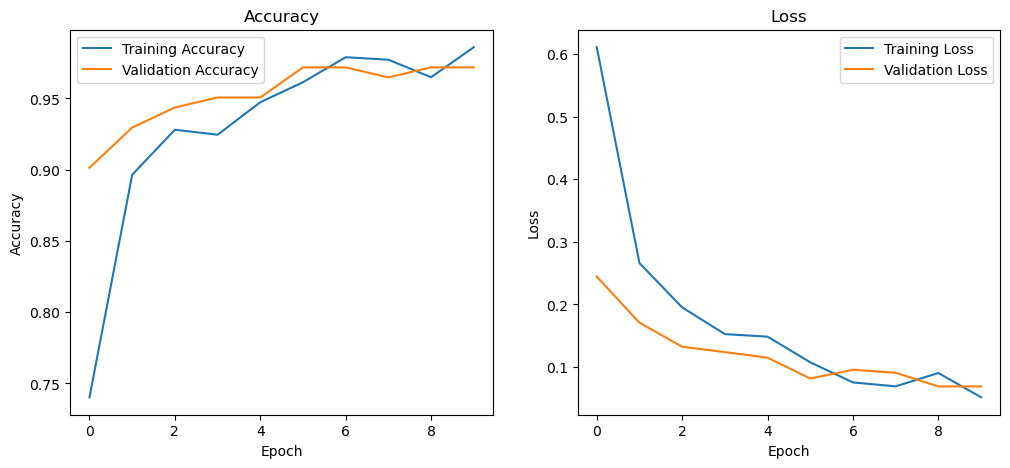

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9519 - loss: 0.0988
Test Accuracy: 0.97 Test Loss: 0.07


In [12]:
"""
Plot Accuracy & Loss for each Epoch
"""
plt.figure(figsize=(12, 5))

# Epoch vs Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"],     label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")

# Epoch vs Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"],     label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "history.png"))
plt.show()

# Show Overall Performance
test_loss, test_acc = best_model.evaluate(validation_dataset)
print(f"Test Accuracy: {test_acc:.2f} Test Loss: {test_loss:.2f}")

In [13]:
"""
Save model and training history
"""
# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

with open(os.path.join(MODEL_NAME, "history.json"), "w") as file:
    json.dump(history.history, file)

best_model.save(os.path.join(MODEL_NAME, "model.keras"))

# Section 4 - Model Evaluation using a Confusion Matrix

In this section, we will use the best model from the previous section to create a Confusion Matrix.

In [14]:
"""
Load the model trained using the best hyperparameters
"""
best_model = load_model(os.path.join(MODEL_NAME, "model.keras"))

In [16]:
"""
Predict each image in the test dataset
"""
testing_dataset = image_dataset_from_directory(
    TESTING_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Apply ResNet50's image preprocessing
testing_dataset = testing_dataset.map(lambda x, y: (preprocess_input(x), y))

actual = []
predictions = []

for batch, labels in validation_dataset:
    results = best_model.predict(batch)  # Get raw predictions
    predicted_labels = (results > 0.5).astype(int).flatten()  # Convert probabilities to 0s and 1s
    predictions.extend(predicted_labels)  # Append predicted labels
    actual.extend(labels.numpy())  # Convert actual labels to list

print("Actual Labels:   ", actual)
print("Predicted Labels:", predictions)

Found 45 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Actual Labels:    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Predicted Labels: [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,

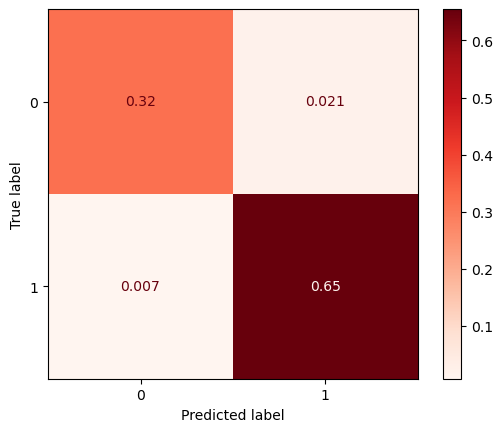

Accuracy: 0.971830985915493


In [17]:
"""
Plot a Confusion Matrix of the test dataset predictions
"""
result = confusion_matrix(actual, predictions, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot(cmap="Reds")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "confusionmatrix.png"))
plt.show()

with open(os.path.join(MODEL_NAME, "confusionmatrix.json"), "w") as file:
    json.dump(result.tolist(), file)

print(f"Accuracy: {result[0][0] + result[1][1]}")

# Section 5 - Model Evaluation using K-Fold Cross Validation

In this section, we will train the model K times with the best hyperparameters identified in section 2. The average accuracy of all folds will be calculated to determine if there is an overfit.

In [18]:
"""
Load the saved GridSearch results
"""
filtered_results = pd.read_csv(os.path.join(MODEL_NAME, "gridsearch.csv"))

# Get the top-ranked result (rank_test_score == 1)
best_result = filtered_results[filtered_results["rank_test_score"] == 1].iloc[0]

# Extract optimizer and learning rate
best_optimizer = best_result["param_model__optimizer"]
best_learning_rate = best_result["param_model__learning_rate"]

best_optimizer, best_learning_rate

('Adam', 0.001)

In [19]:
"""
Load the training dataset
"""
dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Apply ResNet50's image preprocessing
dataset = dataset.map(lambda x, y: (preprocess_input(x), y))

Found 712 files belonging to 2 classes.


In [20]:
"""
Prepare the data to be compatible with the K-Folds API
"""

# Function to convert TF dataset to NumPy arrays
def dataset_to_numpy(dataset):
    all_images, all_labels = [], []
    for images, labels in dataset:
        all_images.append(images.numpy())  # Convert images to NumPy
        all_labels.append(labels.numpy())  # Convert labels to NumPy
    return np.vstack(all_images), np.hstack(all_labels)

# Convert datasets for GridSearch compatibility
images, labels = dataset_to_numpy(dataset)

In [21]:
"""
Perform K-Fold Cross-Validation
"""

kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold = 1
accuracies = []

for train_index, val_index in kf.split(images):
    print(f"Training on Fold {fold}/{K_FOLDS}...")

    # Split the data according to current fold
    training_images, validation_images = images[train_index], images[val_index]
    training_labels, validation_labels = labels[train_index], labels[val_index]

    # Define and compile model using the best hyperparameters
    model = create_model(
        optimizer=best_optimizer,
        learning_rate=best_learning_rate,
    )
    
    # Train the model using the fold
    history = model.fit(
        training_images,
        training_labels,
        validation_data=(
            validation_images,
            validation_labels
        ),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    # Calculate and keep track of the score
    scores = model.evaluate(validation_images, validation_labels, verbose=0)
    print(f"Fold {fold} Accuracy: {scores[1] * 100:.2f}%")

    accuracies.append(scores[1] * 100)
    fold += 1

Training on Fold 1/5...
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 691ms/step - accuracy: 0.6501 - loss: 1.1796 - val_accuracy: 0.8951 - val_loss: 0.2415
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8570 - loss: 0.3246 - val_accuracy: 0.9091 - val_loss: 0.2020
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9084 - loss: 0.2313 - val_accuracy: 0.9371 - val_loss: 0.1645
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9181 - loss: 0.1987 - val_accuracy: 0.9021 - val_loss: 0.2154
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9313 - loss: 0.1579 - val_accuracy: 0.9231 - val_loss: 0.1658
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9676 - loss: 0.1003 - val_accuracy: 0.9301 - val_loss: 0.1374
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.9564 - loss: 0.0999 - val_accuracy: 0.9301 - val_loss: 0.1520
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.9823 - loss: 

2025-03-23 10:34:20.916571: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 670ms/step - accuracy: 0.7142 - loss: 0.7386 - val_accuracy: 0.8951 - val_loss: 0.2712
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.8723 - loss: 0.2938 - val_accuracy: 0.9161 - val_loss: 0.2152
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9058 - loss: 0.1877 - val_accuracy: 0.9021 - val_loss: 0.1954
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9121 - loss: 0.2093 - val_accuracy: 0.9301 - val_loss: 0.1698
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9515 - loss: 0.1428 - val_accuracy: 0.9441 - val_loss: 0.1261
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9696 - loss: 0.0910 - val_accuracy: 0.9580 - val_loss: 0.1241
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9666 - loss: 0.0792 - val_accuracy: 0.9441 - val_loss: 0.1052
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9706 - loss: 0.0871 - val_accuracy: 0.9650 - val

2025-03-23 10:35:54.417960: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7439 - loss: 0.7352 - val_accuracy: 0.8944 - val_loss: 0.2301
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.8628 - loss: 0.3056 - val_accuracy: 0.9437 - val_loss: 0.1740
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9465 - loss: 0.1662 - val_accuracy: 0.9507 - val_loss: 0.1237
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9564 - loss: 0.1310 - val_accuracy: 0.9507 - val_loss: 0.1072
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9497 - loss: 0.1099 - val_accuracy: 0.9577 - val_loss: 0.0814
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9654 - loss: 0.1174 - val_accuracy: 0.9718 - val_loss: 0.0681
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9746 - loss: 0.0790 - val_accuracy: 0.9648 - val_loss: 0.0755
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9860 - loss: 0.0617 - val_accuracy: 0.9648 - val_lo

2025-03-23 10:37:54.182432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 66s 964ms/step - accuracy: 0.6844 - loss: 0.8891 - val_accuracy: 0.8451 - val_loss: 0.3279
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 355ms/step - accuracy: 0.8972 - loss: 0.2586 - val_accuracy: 0.9014 - val_loss: 0.2392
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9078 - loss: 0.2231 - val_accuracy: 0.8873 - val_loss: 0.2533
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9189 - loss: 0.1880 - val_accuracy: 0.9014 - val_loss: 0.2000
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9621 - loss: 0.1334 - val_accuracy: 0.9225 - val_loss: 0.1633
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9689 - loss: 0.1059 - val_accuracy: 0.9225 - val_loss: 0.1449
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9513 - loss: 0.1228 - val_accuracy: 0.9437 - val_loss: 0.1314
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9660 - loss: 0.0816 - val_accuracy: 0.9437 - va

2025-03-23 10:39:47.986300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 926ms/step - accuracy: 0.6568 - loss: 0.8144 - val_accuracy: 0.9296 - val_loss: 0.1943
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.8660 - loss: 0.3352 - val_accuracy: 0.9437 - val_loss: 0.1596
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9106 - loss: 0.1882 - val_accuracy: 0.9648 - val_loss: 0.1368
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9239 - loss: 0.2182 - val_accuracy: 0.9718 - val_loss: 0.1096
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9489 - loss: 0.1176 - val_accuracy: 0.9859 - val_loss: 0.0780
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9687 - loss: 0.0988 - val_accuracy: 0.9437 - val_loss: 0.1117
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.9540 - loss: 0.1083 - val_accuracy: 0.9930 - val_loss: 0.0523
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - accuracy: 0.9758 - loss: 0.0845 - val_accuracy: 0.9930 - va

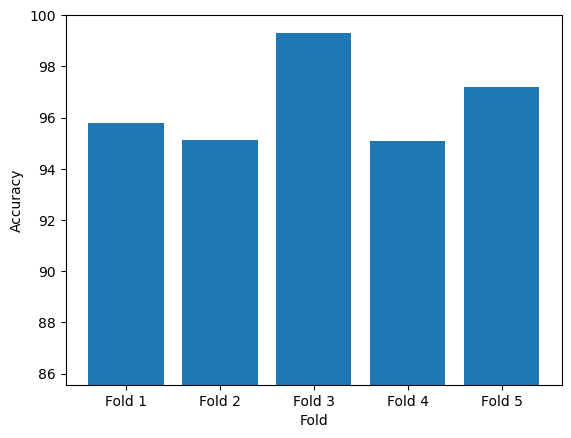

Average Accuracy: 96.49% ± 1.60%


In [23]:
"""
Plot the accuracy for each fold
"""

plt.bar([f"Fold {n}" for n in range(1, K_FOLDS + 1)], accuracies)

# Auto-rescale the bars
plt.ylim(
    min(accuracies) * 0.9,          # 0.9 to make the smallest bar still visible
    min(max(accuracies) * 1.1, 100) # 1.1 to make extra space above the  largest bar
)
plt.xlabel("Fold")
plt.ylabel("Accuracy")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "kfold.png"))
plt.show()

print(f"Average Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")

In [24]:
"""
Save K-Fold score
"""
# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

with open(os.path.join(MODEL_NAME, "kfold.json"), "w") as file:
    json.dump(accuracies, file)